In [1]:
import pandas as pd

df=pd.read_csv('train.csv')

#df.plot.hist()
labels= df.Label
#print(df)

#for i in range(df.shape[0]):
#    print(df.ID[i], df.Label[i])


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import plot_model, to_categorical
from keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, f1_score

import glob
import imageio
import numpy as np
import os.path as path
from datetime import datetime

# Image processing
IMAGE_PATH='train_images/'

image_input_files = [IMAGE_PATH + s for s in df.ID]
#print(image_input_files)

#image_input_files = sorted(glob.glob(path.join(IMAGE_PATH, '*.png')))
images = [imageio.imread(im) for im in image_input_files]
images = np.asarray(images)

images = images/256
print(images)


Using TensorFlow backend.


[[[0.65625    0.6796875  0.6953125  ... 0.73046875 0.69140625 0.6953125 ]
  [0.73046875 0.68359375 0.68359375 ... 0.71484375 0.69921875 0.703125  ]
  [0.7265625  0.69921875 0.73046875 ... 0.6953125  0.70703125 0.70703125]
  ...
  [0.6875     0.67578125 0.65234375 ... 0.6640625  0.66015625 0.66015625]
  [0.68359375 0.6484375  0.66015625 ... 0.65625    0.66796875 0.67578125]
  [0.68359375 0.65625    0.66015625 ... 0.68359375 0.66015625 0.6640625 ]]

 [[0.734375   0.71875    0.640625   ... 0.71484375 0.67578125 0.68359375]
  [0.69140625 0.72265625 0.6328125  ... 0.63671875 0.671875   0.7265625 ]
  [0.7734375  0.76953125 0.703125   ... 0.6796875  0.6484375  0.6328125 ]
  ...
  [0.64453125 0.61328125 0.66015625 ... 0.66015625 0.6953125  0.66796875]
  [0.59375    0.60546875 0.66015625 ... 0.62890625 0.62890625 0.625     ]
  [0.625      0.6484375  0.6796875  ... 0.640625   0.62109375 0.57421875]]

 [[0.69140625 0.69140625 0.67578125 ... 0.64453125 0.65234375 0.66796875]
  [0.68359375 0.6875  

In [3]:
from sklearn.model_selection import train_test_split

num_classes = 6
img_rows = 128
img_cols = 128

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.30)


x_train = x_train.reshape(x_train.shape[0], 16384)
x_test = x_test.reshape(x_test.shape[0], 16384)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

#x_train = x_train.reshape(x_train.shape[0], img_rows * img_cols, 1)
#x_test = x_test.reshape(x_test.shape[0], img_rows * img_cols, 1)
#input_shape = (img_rows * img_cols, 1)
    
y_train=to_categorical(y_train, num_classes)
y_test=to_categorical(y_test, num_classes)

print(x_train)
#print(x_test.ndim)

#print(y_train)
#print(y_test)

1769 train samples
759 test samples
[[0.00258885 0.00252757 0.00248162 ... 0.00373775 0.00379902 0.00358456]
 [0.00269608 0.00261949 0.00257353 ... 0.00238971 0.00235907 0.00238971]
 [0.00292586 0.00292586 0.00292586 ... 0.00292586 0.00294118 0.00294118]
 ...
 [0.00219056 0.00215993 0.00232843 ... 0.00211397 0.00229779 0.00228248]
 [0.00294118 0.00294118 0.0029565  ... 0.00386029 0.00390625 0.00390625]
 [0.00242034 0.00254289 0.00261949 ... 0.00370711 0.00359988 0.00358456]]


In [4]:
# updatable plot
# a minimal example (sort of)
import matplotlib.pyplot as plt
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_start(self, epoch, logs={}):
        EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')
        
    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
        plt.plot(self.x, self.acc, label="acc")
        plt.plot(self.x, self.val_acc, label="val_acc")
        plt.legend()
        plt.show()
        
plot_losses = PlotLosses()

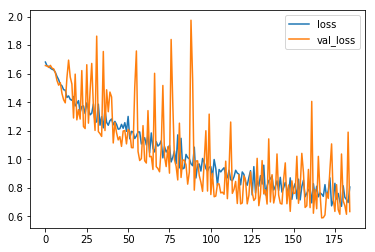

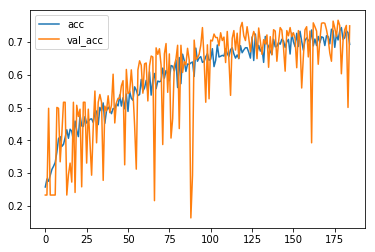

Epoch 186/1500
1600/1769 [==========================>...] - ETA: 0s - loss: 0.6713 - acc: 0.7469

KeyboardInterrupt: 

In [5]:
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(16384,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.summary()

batch_size=100
epochs=1500

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[plot_losses],  validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


In [ ]:
model.save('mlp.h5')

In [ ]:
model.summary()

In [ ]:
if __name__ == '__main__':  # it's better to add this line as suggested
    main()